### Import des modules necéssaires au projet

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import math
import seaborn as sns 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


### Requête SQL pour la dernière date de commande 

**Résultat :** *2018-10-17 17:30:18*

## Explications

### Méthode de Calcul du Score ARI pour l'Évaluation de la Stabilité du Modèle

1. **Objectif :** Évaluer la stabilité d'un modèle de segmentation client basé sur des données historiques.

2. **Étapes :**
   - **Initialisation :** Utilisation de données clients incluant la récence des commandes, la satisfaction moyenne et le montant moyen des commandes.
   - **Segmentation Initiale :** Entraînement d'un modèle K-means initial pour diviser les clients en clusters.
   - **Évaluation Temporelle :** Segmenter les clients à intervalles réguliers pour évaluer la stabilité du modèle.
   - **Calcul du Score ARI :** Utilisation de l'Adjusted Rand Index (ARI) pour mesurer la cohérence des clusters prédits sur des périodes successives.
   - **Ré-Entraînement :** Identifier les périodes nécessitant une mise à jour du modèle lorsque le score ARI indique une instabilité.

3. **Résultats Attendus :**
   - Visualisation de l'évolution des scores ARI au fil du temps.
   - Détermination des périodes critiques nécessitant une mise à jour du modèle pour maintenir la précision de la segmentation client.


#### Chargement du jeu de données du précédent notebook de modélisation

In [2]:
import pandas as pd

# Définir le chemin du fichier CSV
file_path = r"C:\Users\pdevi\OneDrive\Desktop\OpenClassrooms\Projet_3\DATA_LAST\data_cleaned.csv"

# Lire le fichier CSV dans un DataFrame
data_retrieved = pd.read_csv(file_path)

# Afficher les premières lignes du DataFrame pour vérifier
print(data_retrieved.head())


                 customer_unique_id  days_since_last_order  average_days_diff  \
0  ffffd2657e2aad2907e67c3e9daecbeb             532.883021         532.883021   
1  ffff5962728ec6157033ef9805bacc48             168.092095         168.092095   
2  ffff371b4d645b6ecea244b27531430a             617.070162         617.070162   
3  fffea47cd6d3cc0a88bd621562a9d061             310.890532         310.890532   
4  fffcf5a5ff07b0908bd4e2dbc735a684             495.853958         495.853958   

   std_dev_days_diff  mean_order_reviews_score_of_given_client  \
0                0.0                                       5.0   
1                0.0                                       5.0   
2                0.0                                       5.0   
3                0.0                                       4.0   
4                0.0                                       5.0   

   average_order_price_of_client  non_cancelled_orders_count  \
0                          56.99                    

In [3]:
# import sqlite3
# import pandas as pd
# from datetime import datetime, timedelta
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import adjusted_rand_score, silhouette_score
# import matplotlib.pyplot as plt
# import numpy as np

# def obtenir_donnees_par_temporalite(db_path, date_debut, date_fin):
    
#     """
# Obtient les données agrégées sur plusieurs variables pour chaque client dans une période temporelle spécifiée.

# Args:
#     db_path (str): Chemin vers la base de données SQLite contenant les données.
#     date_debut (str): Date de début de la période temporelle au format 'YYYY-MM-DD'.
#     date_fin (str): Date de fin de la période temporelle au format 'YYYY-MM-DD'.

# Returns:
#     pd.DataFrame: Dataframe contenant les données agrégées pour chaque client sur les variables spécifiées.
# """

    
#     conn = sqlite3.connect(db_path)
    
#     requetes = {
#         'mean_order_reviews_score_of_given_client': f'''
#             SELECT c.customer_unique_id,
#                    COALESCE(AVG(CASE WHEN orv.review_score IS NOT NULL THEN orv.review_score END), 0) AS mean_order_reviews_score_of_given_client
#             FROM orders o
#             JOIN customers c ON o.customer_id = c.customer_id
#             LEFT JOIN order_reviews orv ON o.order_id = orv.order_id
#             WHERE o.order_purchase_timestamp BETWEEN '{date_debut}' AND '{date_fin}'
#             GROUP BY c.customer_unique_id
#             ORDER BY c.customer_unique_id DESC;
#         ''',
#         'average_order_price_of_client': f'''
#             SELECT c.customer_unique_id,
#                    COALESCE(AVG(CASE WHEN oi.price IS NOT NULL THEN oi.price END), 0) AS average_order_price_of_client
#             FROM orders o
#             JOIN customers c ON o.customer_id = c.customer_id
#             LEFT JOIN order_items oi ON o.order_id = oi.order_id
#             WHERE o.order_purchase_timestamp BETWEEN '{date_debut}' AND '{date_fin}'
#             GROUP BY c.customer_unique_id
#             ORDER BY c.customer_unique_id DESC;
#         ''',
#         'non_cancelled_orders_count': f'''
#             SELECT c.customer_unique_id,
#                    COUNT(*) AS non_cancelled_orders_count
#             FROM orders o
#             JOIN customers c ON o.customer_id = c.customer_id
#             WHERE o.order_status != 'canceled' AND o.order_purchase_timestamp BETWEEN '{date_debut}' AND '{date_fin}'
#             GROUP BY c.customer_unique_id
#             ORDER BY c.customer_unique_id DESC;
#         ''',
#         'total_order_price_of_client': f'''
#             SELECT c.customer_unique_id,
#                    COALESCE(SUM(oi.price), 0) AS total_order_price_of_client
#             FROM orders o
#             JOIN customers c ON o.customer_id = c.customer_id
#             JOIN order_items oi ON o.order_id = oi.order_id
#             WHERE o.order_purchase_timestamp BETWEEN '{date_debut}' AND '{date_fin}'
#             GROUP BY c.customer_unique_id
#             ORDER BY c.customer_unique_id DESC;
#         ''',
#         'days_since_last_order': f'''
#             SELECT c.customer_unique_id,
#                    (julianday('{date_fin}') - julianday(MAX(o.order_purchase_timestamp))) AS days_since_last_order
#             FROM orders o
#             JOIN customers c ON o.customer_id = c.customer_id
#             WHERE o.order_purchase_timestamp BETWEEN '{date_debut}' AND '{date_fin}'
#             GROUP BY c.customer_unique_id
#             ORDER BY c.customer_unique_id DESC;
#         '''
#     }
    
#     data_frames = {}
#     for key, query in requetes.items():
#         data_frames[key] = pd.read_sql_query(query, conn)
    
#     conn.close()
    
#     # Fusionner les dataframes sur 'customer_unique_id'
#     merged_data = data_frames['mean_order_reviews_score_of_given_client']
#     for key, df in data_frames.items():
#         if key != 'mean_order_reviews_score_of_given_client':
#             merged_data = merged_data.merge(df, on='customer_unique_id', how='left')
    
#     # Supprimer les lignes avec des valeurs NaN
#     merged_data.dropna(inplace=True)
    
#     return merged_data

# def plotter_elbow_methode(scaled_data):
    
#     """
# Affiche le graphique de la méthode du coude pour déterminer le nombre optimal de clusters.

# Args:
#     scaled_data (pd.DataFrame): Données mises à l'échelle pour l'application de l'algorithme K-means.
# """

    
#     inertias = []
#     k_range = range(1, 11)
#     for k in k_range:
#         kmeans = KMeans(n_clusters=k, random_state=42)
#         kmeans.fit(scaled_data)
#         inertias.append(kmeans.inertia_)
    
#     plt.figure(figsize=(8, 4))
#     plt.plot(k_range, inertias, 'bo-')
#     plt.xlabel('Nombre de clusters (k)')
#     plt.ylabel('Inertie')
#     plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
#     plt.show()

# def plot_silhouette_method(scaled_data):
    
#     """
# Affiche le graphique de la méthode de silhouette pour déterminer le nombre optimal de clusters.

# Args:
#     scaled_data (pd.DataFrame): Données mises à l'échelle pour l'application de l'algorithme K-means.
# """

    
#     sample_size = 10000
#     random_indices = np.random.choice(scaled_data.shape[0], size=sample_size, replace=False)
#     sampled_data = scaled_data.iloc[random_indices, :]
    
#     silhouette_scores = []
#     k_range = range(2, 11)
#     for k in k_range:
#         kmeans = KMeans(n_clusters=k, random_state=42)
#         labels = kmeans.fit_predict(sampled_data)
#         silhouette_avg = silhouette_score(sampled_data, labels)
#         silhouette_scores.append(silhouette_avg)
    
#     plt.figure(figsize=(8, 4))
#     plt.plot(k_range, silhouette_scores, 'bo-')
#     plt.xlabel('Nombre de clusters (k)')
#     plt.ylabel('Score de silhouette moyen')
#     plt.title('Méthode de silhouette pour déterminer le nombre optimal de clusters')
#     plt.show()

# def entrainer_modele(data, selected_columns):
    
#     """
# Entraîne un modèle K-means pour segmenter les clients en clusters basés sur les colonnes sélectionnées.

# Args:
#     data (pd.DataFrame): Données à utiliser pour l'entraînement du modèle.
#     selected_columns (list): Liste des colonnes à inclure dans l'entraînement du modèle.

# Returns:
#     tuple: Objet scaler utilisé pour la mise à l'échelle, modèle K-means entraîné, et labels des clusters.
# """

    
#     scaler = StandardScaler()
#     scaled_data = pd.DataFrame(scaler.fit_transform(data[selected_columns]), columns=selected_columns)
    
#     # Méthode du coude
#     plotter_elbow_methode(scaled_data)
    
#     # Méthode silhouette
#     plot_silhouette_method(scaled_data)
    
#     # Demander à l'utilisateur de choisir le nombre de clusters
#     n_clusters = int(input("Veuillez entrer le nombre optimal de clusters basé sur les graphiques: "))
    
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     kmeans.fit(scaled_data)
#     return scaler, kmeans, kmeans.labels_

# def calculer_ari(db_path, date_derniere_commande, initial_date_debut, temporalite_jours, initial_scaler, initial_model, initial_data, selected_columns, seuil_ari=0.8):
    
#     """
# Calcule les scores ARI sur des périodes temporelles successives pour évaluer la stabilité du modèle.

# Args:
#     db_path (str): Chemin vers la base de données SQLite contenant les données.
#     date_derniere_commande (str): Date de la dernière commande au format 'YYYY-MM-DD'.
#     initial_date_debut (str): Date de début initiale pour le calcul des scores ARI au format 'YYYY-MM-DD'.
#     temporalite_jours (int): Nombre de jours pour chaque période temporelle.
#     initial_scaler (StandardScaler): Objet de mise à l'échelle initial utilisé pour les données d'entraînement.
#     initial_model (KMeans): Modèle K-means initial entraîné sur les données d'entraînement.
#     initial_data (pd.DataFrame): Données initiales utilisées pour l'entraînement du modèle.
#     selected_columns (list): Liste des colonnes sélectionnées pour l'évaluation du modèle.
#     seuil_ari (float): Seuil de score ARI pour déterminer la nécessité de réentraîner le modèle.

# Returns:
#     list: Liste des scores ARI calculés pour chaque période temporelle.
# """

    
#     datetime_derniere_commande = datetime.strptime(date_derniere_commande, '%Y-%m-%d')
#     datetime_debut = datetime.strptime(initial_date_debut, '%Y-%m-%d') + timedelta(days=365)  # Start after the initial year
#     ari_scores = []
#     break_condition=0
#     nb_jours_ecoules=0
#     while datetime_debut < datetime_derniere_commande:
#         date_fin_split = datetime_debut + timedelta(days=temporalite_jours)
#         if date_fin_split > datetime_derniere_commande:
#             date_fin_split = datetime_derniere_commande
        
#         # Obtenir les données pour cette période spécifique
#         split_df = obtenir_donnees_par_temporalite(db_path, initial_date_debut, date_fin_split.strftime('%Y-%m-%d'))
        
#         # Filtrer les données pour les clients communs avec les données initiales
#         common_ids = split_df['customer_unique_id'].isin(initial_data['customer_unique_id'])
#         aligned_split_df = split_df[common_ids]
        
#         common_ids_initial = initial_data['customer_unique_id'].isin(aligned_split_df['customer_unique_id'])
#         aligned_initial_data = initial_data[common_ids_initial]
        
#         if aligned_initial_data.empty or aligned_split_df.empty:
#             break
        
#         # Scaling des données
#         scaled_initial_data = initial_scaler.transform(aligned_initial_data[selected_columns])
#         scaled_split_data = initial_scaler.transform(aligned_split_df[selected_columns])
        
#         # Prédiction des clusters avec le modèle initial
#         initial_clusters = initial_model.predict(scaled_initial_data)
#         split_clusters = initial_model.predict(scaled_split_data)
        
#         # Calcul de l'ARI
#         ari = adjusted_rand_score(initial_clusters, split_clusters)
#         ari_scores.append(ari)
#         nb_jours_ecoules += temporalite_jours
#         if ari < seuil_ari:
            
#             break_condition+=1
            
#             if break_condition==1:
                
#                 print("Le modèle doit réetraîné au bout de ", nb_jours_ecoules," jours")
                
#             print(f"Réentraînement nécessaire pour la période se terminant le {date_fin_split.date()}")
#             print("Score ARI : ", ari)
#             if break_condition==5:
                
#                 break
            
        
#         datetime_debut += timedelta(days=temporalite_jours)
    
#     return ari_scores



# def plotter_ari(ari_scores):
#     plt.plot(range(1, len(ari_scores) + 1), ari_scores, marker='o')
#     plt.xlabel('Split')
#     plt.ylabel('ARI')
#     plt.title('Évolution des scores ARI')
#     plt.axhline(y=0.8, color='r', linestyle='--')
#     plt.show()


import sqlite3
import pandas as pd
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, silhouette_score
import matplotlib.pyplot as plt
import numpy as np

def obtenir_donnees_par_temporalite(db_path, date_debut, date_fin):
    conn = sqlite3.connect(db_path)
    
    requetes = {
        'mean_order_reviews_score_of_given_client': f'''
            SELECT c.customer_unique_id,
                   COALESCE(AVG(CASE WHEN orv.review_score IS NOT NULL THEN orv.review_score END), 0) AS mean_order_reviews_score_of_given_client
            FROM orders o
            JOIN customers c ON o.customer_id = c.customer_id
            LEFT JOIN order_reviews orv ON o.order_id = orv.order_id
            WHERE o.order_purchase_timestamp BETWEEN '{date_debut}' AND '{date_fin}'
            GROUP BY c.customer_unique_id
            ORDER BY c.customer_unique_id DESC;
        ''',
        'average_order_price_of_client': f'''
            SELECT c.customer_unique_id,
                   COALESCE(AVG(CASE WHEN oi.price IS NOT NULL THEN oi.price END), 0) AS average_order_price_of_client
            FROM orders o
            JOIN customers c ON o.customer_id = c.customer_id
            LEFT JOIN order_items oi ON o.order_id = oi.order_id
            WHERE o.order_purchase_timestamp BETWEEN '{date_debut}' AND '{date_fin}'
            GROUP BY c.customer_unique_id
            ORDER BY c.customer_unique_id DESC;
        ''',
        'non_cancelled_orders_count': f'''
            SELECT c.customer_unique_id,
                   COUNT(*) AS non_cancelled_orders_count
            FROM orders o
            JOIN customers c ON o.customer_id = c.customer_id
            WHERE o.order_status != 'canceled' AND o.order_purchase_timestamp BETWEEN '{date_debut}' AND '{date_fin}'
            GROUP BY c.customer_unique_id
            ORDER BY c.customer_unique_id DESC;
        ''',
        'total_order_price_of_client': f'''
            SELECT c.customer_unique_id,
                   COALESCE(SUM(oi.price), 0) AS total_order_price_of_client
            FROM orders o
            JOIN customers c ON o.customer_id = c.customer_id
            JOIN order_items oi ON o.order_id = oi.order_id
            WHERE o.order_purchase_timestamp BETWEEN '{date_debut}' AND '{date_fin}'
            GROUP BY c.customer_unique_id
            ORDER BY c.customer_unique_id DESC;
        ''',
        'days_since_last_order': f'''
            SELECT c.customer_unique_id,
                   (julianday('{date_fin}') - julianday(MAX(o.order_purchase_timestamp))) AS days_since_last_order
            FROM orders o
            JOIN customers c ON o.customer_id = c.customer_id
            WHERE o.order_purchase_timestamp BETWEEN '{date_debut}' AND '{date_fin}'
            GROUP BY c.customer_unique_id
            ORDER BY c.customer_unique_id DESC;
        '''
    }
    
    data_frames = {}
    for key, query in requetes.items():
        data_frames[key] = pd.read_sql_query(query, conn)
    
    conn.close()
    
    merged_data = data_frames['mean_order_reviews_score_of_given_client']
    for key, df in data_frames.items():
        if key != 'mean_order_reviews_score_of_given_client':
            merged_data = merged_data.merge(df, on='customer_unique_id', how='left')
    
    merged_data.dropna(inplace=True)
    
    return merged_data

def plotter_elbow_methode(scaled_data):
    inertias = []
    k_range = range(1, 11)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(scaled_data)
        inertias.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 4))
    plt.plot(k_range, inertias, 'bo-')
    plt.xlabel('Nombre de clusters (k)')
    plt.ylabel('Inertie')
    plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
    plt.show()

def plot_silhouette_method(scaled_data):
    sample_size = 15000
    random_indices = np.random.choice(scaled_data.shape[0], size=sample_size, replace=False)
    sampled_data = scaled_data.iloc[random_indices, :]
    
    silhouette_scores = []
    k_range = range(2, 11)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(sampled_data)
        silhouette_avg = silhouette_score(sampled_data, labels)
        silhouette_scores.append(silhouette_avg)
    
    plt.figure(figsize=(8, 4))
    plt.plot(k_range, silhouette_scores, 'bo-')
    plt.xlabel('Nombre de clusters (k)')
    plt.ylabel('Score de silhouette moyen')
    plt.title('Méthode de silhouette pour déterminer le nombre optimal de clusters')
    plt.show()

def entrainer_modele(data, selected_columns):
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data[selected_columns]), columns=selected_columns)
    
    plotter_elbow_methode(scaled_data)
    
    plot_silhouette_method(scaled_data)
    
    n_clusters = int(input("Veuillez entrer le nombre optimal de clusters basé sur les graphiques: "))
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_data)
    return scaler, kmeans, kmeans.labels_,n_clusters

def entrainer_modele_fixed(data, selected_columns,n_clusters):
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data[selected_columns]), columns=selected_columns)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_data)
    return scaler, kmeans, kmeans.labels_

def calculer_ari(db_path, date_derniere_commande, initial_date_debut, temporalite_jours, initial_scaler, initial_model, initial_data, selected_columns,n_clusters, seuil_ari=0.8):
    datetime_derniere_commande = datetime.strptime(date_derniere_commande, '%Y-%m-%d')
    datetime_debut = datetime.strptime(initial_date_debut, '%Y-%m-%d') + timedelta(days=365)  
    ari_scores = []
    break_condition = 0
    nb_jours_ecoules = 0

    while datetime_debut < datetime_derniere_commande:
        date_fin_split = datetime_debut + timedelta(days=temporalite_jours)
        if date_fin_split > datetime_derniere_commande:
            date_fin_split = datetime_derniere_commande
        
        split_df = obtenir_donnees_par_temporalite(db_path, initial_date_debut, date_fin_split.strftime('%Y-%m-%d'))
        
        common_ids = split_df['customer_unique_id'].isin(initial_data['customer_unique_id'])
        aligned_split_df = split_df[common_ids]
        
        common_ids_initial = initial_data['customer_unique_id'].isin(aligned_split_df['customer_unique_id'])
        aligned_initial_data = initial_data[common_ids_initial]
        
        if aligned_initial_data.empty or aligned_split_df.empty:
            break
        
        scaled_initial_data = initial_scaler.transform(aligned_initial_data[selected_columns])
        scaled_split_data = initial_scaler.transform(aligned_split_df[selected_columns])
        
        initial_clusters = initial_model.predict(scaled_split_data)
        
        # Réentraîner un nouveau modèle sur la nouvelle période cumulative
        new_scaler, new_model, new_labels = entrainer_modele_fixed(aligned_split_df, selected_columns,n_clusters)
        split_clusters = new_model.predict(scaled_split_data)
        
        ari = adjusted_rand_score(initial_clusters, split_clusters)
        ari_scores.append(ari)
        nb_jours_ecoules += temporalite_jours

        if ari < seuil_ari:
            break_condition += 1
            if break_condition == 1:
                print("Le modèle doit réentraîner au bout de ", nb_jours_ecoules, " jours")
            print(f"Réentraînement nécessaire pour la période se terminant le {date_fin_split.date()}")
            print("Score ARI : ", ari)
            if break_condition == 5:
                break
        
        datetime_debut += timedelta(days=temporalite_jours)
    
    return ari_scores

def plotter_ari(ari_scores):
    plt.plot(range(1, len(ari_scores) + 1), ari_scores, marker='o')
    plt.xlabel('Split')
    plt.ylabel('ARI')
    plt.title('Évolution des scores ARI')
    plt.axhline(y=0.8, color='r', linestyle='--')
    plt.show()


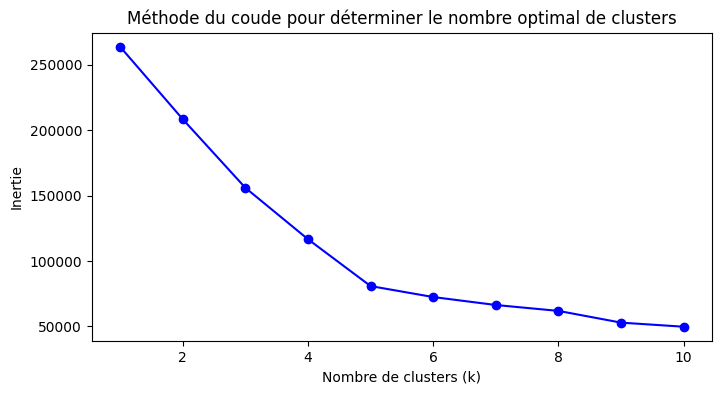

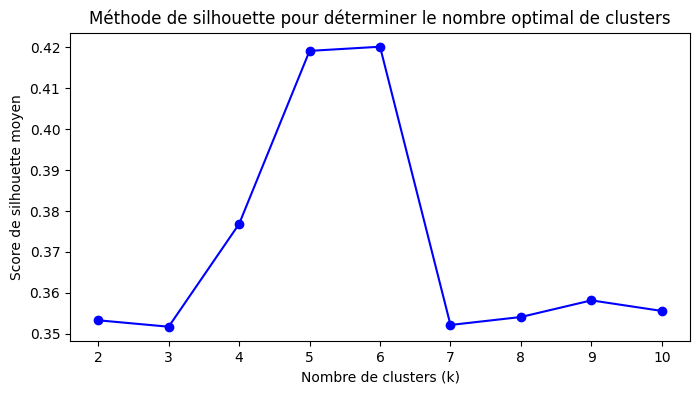

Veuillez entrer le nombre optimal de clusters basé sur les graphiques:  5


Le modèle doit réentraîner au bout de  25  jours
Réentraînement nécessaire pour la période se terminant le 2018-06-26
Score ARI :  0.7955744640177815
Réentraînement nécessaire pour la période se terminant le 2018-08-25
Score ARI :  0.45708148961245876
Réentraînement nécessaire pour la période se terminant le 2018-08-30
Score ARI :  0.7823956862136598
Réentraînement nécessaire pour la période se terminant le 2018-09-04
Score ARI :  0.776355190451084
Réentraînement nécessaire pour la période se terminant le 2018-09-09
Score ARI :  0.7719024769538024


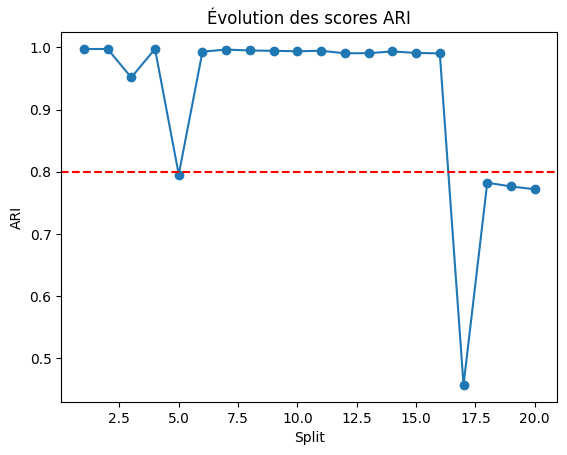

In [4]:
# Chemin vers la base de données
db_path = r"C:\Users\pdevi\OneDrive\Desktop\OpenClassrooms\Projet_3\olist.db"

# Détermination de la première année de données
date_debut_initial = '2017-06-01'

nb_days_training=365
# Entraînement initial du modèle sur la première année de données
initial_data = obtenir_donnees_par_temporalite(db_path, date_debut_initial, (datetime.strptime(date_debut_initial, '%Y-%m-%d') + timedelta(days=nb_days_training)).strftime('%Y-%m-%d'))

# Préparation des données initiales
selected_columns = ['mean_order_reviews_score_of_given_client', 'average_order_price_of_client',
                    'non_cancelled_orders_count', 'days_since_last_order']

initial_scaler, initial_model, initial_clusters,n_clusters = entrainer_modele(initial_data, selected_columns)

# Calcul des scores ARI avec périodes cumulatives
date_derniere_commande = '2018-10-17'
temporalite_jours = 5
ari_scores = calculer_ari(db_path, date_derniere_commande, date_debut_initial, temporalite_jours, initial_scaler, initial_model, initial_data, selected_columns,n_clusters)

# Affichage des scores ARI
plotter_ari(ari_scores)
